In [1]:
# general imports usually needed
import numpy as np
import matplotlib as mpl
import matplotlib.animation
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd

In [2]:
# libraries more specific to this lecture notebook
import os.path
import sys
sys.path.append('../src')
from ml_python_class.config import DATA_DIR

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [3]:
# notebook wide settings to make plots more readable and visually better to understand
np.set_printoptions(suppress=True)

#%matplotlib widget
#%matplotlib inline

plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('figure', titlesize=18)
plt.rc('legend', fontsize=14)
plt.rcParams['figure.figsize'] = (12.0, 8.0) # default figure size if not specified in plot
plt.style.use('seaborn-v0_8-darkgrid')


# 4. (Chapter 4) Training Models

In this chapter we will begin our study of Machine Learning algorithms in earnest.  Up
to this point you have gotten a taste of using some ML models as black boxes.
You don't really know internally what they are doing or how they work.  But still, learning
the API of how to create data sets and set up models for training, and knowning in
general what supervisied learning is and how you train a model to fit a dataset is
sufficient to start working with ML.

However, at some point you will be working with a dataset and you will get some
weird or unexpected results.  Also there are myriads of parameters and hyper-parameters,
not to mention issues with formatting and cleaning your data, and tweaking
training procedures, etc. that will all always be a bit mysterious and/or you will only
learn by wrote checklists, if you don't understand some of the fundamentals of the
internal implemenations of the various ML algorithms you use.

Understanding whats under the hood will help you quickly understand what types of ML
models will be promising or not for the data you have.  It will give you an understanding
of the hyper-parameters the model uses, and what you might want to try for these parameters
to get good results.  Understanding whats under the hood will also allow you to debug
and spot issues you have with training and debugging your models.  It will allow you
to perform error analysis, and better understand why your models may be working, and why
they may be failing, so that you can tweak things to improve their performance.

In short, while you can be a push-button/check-list using data analyst, if you eventually
want to improve your skills and become a better data scientist, you need to start
learning the internal working of ML algorithms.  Our goal in this class is to begin
your journey along this path.  We won't become experts on any of the ML methods we 
will look at, but we hope to introduce you to the fundamental concepts and inner
workings, so that you can beging to understand more deeply how the techniques work.

In this chapter, and units of our course, we will begin by looking at **linear regression**
(which we have used already), followed by **logistic regression**.  These units are very
important, as these models have basic concepts that are often similar across many types
of ML algorithms.  We will look at the idea of the **cost function** (or **fitness function**),
and how this can be used with techniques like **gradient descent** to fit the parameters
of a model in general to make predictions about a set of data.  Linear regression
is a technique for performing regression modeling (predict real valued outputs), while
logistic regression is useful for classification (despite its name, which is a bit
misleading at best).  By comparing similarities and differences of cost functions and
fitting models between regression and classification tasks, we will illustrate some general
principles of ML that apply to many types of supervisied learning models, whether
regression or classification tasks.

## 4.3 Polynomial Regression

A best fit regression using the least squared cost function (MSE) can actually do more than fit a simple straight line.  Although this technique doesn't work
with exact solutions, since those depend on solving for the exact linear cost function an expression that can be minimized.  But if we use
gradient descent, we can calculate the gradients even when we have terms other than linear terms.

An example might make this clearer.  This technique can be used to try and fit even larger polynomial functions, beyond 2nd-degree polynomials.  In fact, as we will
see later, you can easily demonstrate the concept of overfitting by fitting very high degree polynomials to data.

As we have been doing, lets create some random data again.  But this time, the true relationship will have a quadratic (2nd-degree) term in our function.
We will model a system governed by a quadratic equation where

$$
y = \frac{1}{2} x^2 + \frac{3}{4}x + 3
$$

plus some noise as before.


In [4]:
# number of samples in our system
m = 100

# x values randomly range from -3 to 3
X = 6 * np.random.rand(m) - 3
#X = np.linspace(-3, 3, 100)

# create y targets
y = 0.5 * X**2.0 + 0.75 * X + 3.0

# but make the y targets a bit noisy, this is normal or gaussian noise, withe a mean of 0 and a standard deviaiton of 0.5 since
# we multiple the noise by 0.5
y = y + np.random.randn(m) * 0.5

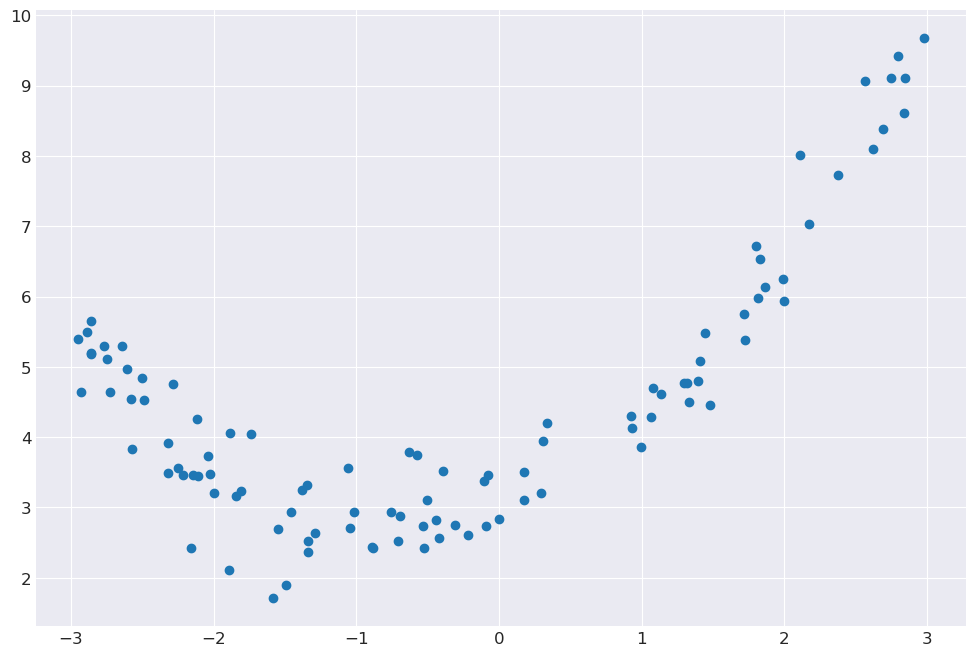

In [5]:
plt.scatter(X, y)

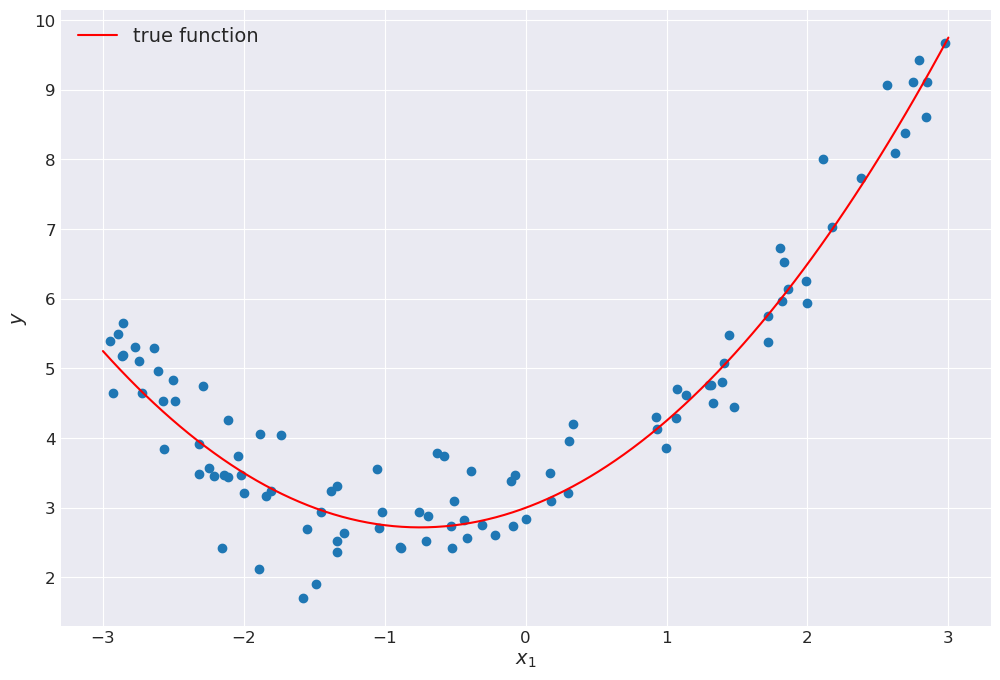

In [6]:
# display the target data, along with the true quadratic function that generated the relationship between
# the variable x and the target value y
plt.scatter(X, y);
x_h = np.linspace(-3.0, 3.0, 100)
y_h = 0.5 * x_h**2.0 + 0.75 * x_h + 3.0
plt.plot(x_h, y_h, 'r-', label='true function')
plt.xlabel(r'$x_1$')
plt.ylabel('$y$')
plt.legend();

Clearly a straight line will not fit the noisy data points, it clearly has some nonlinear relationship.  We could use the `np.polyfit()` from NumPy
to estimate the coefficients of the $x^2$ and the $x$ terms as well as the bias term.

In [7]:
# fit a 2nd degree polynomial to the data, returns the coefficients of the polynomial
# for y = ax^2 + bx + c
(a,b,c) = np.polyfit(X, y, 2)
print(a,b,c)

0.5069429343653236 0.7505073925870286 3.03377780643864


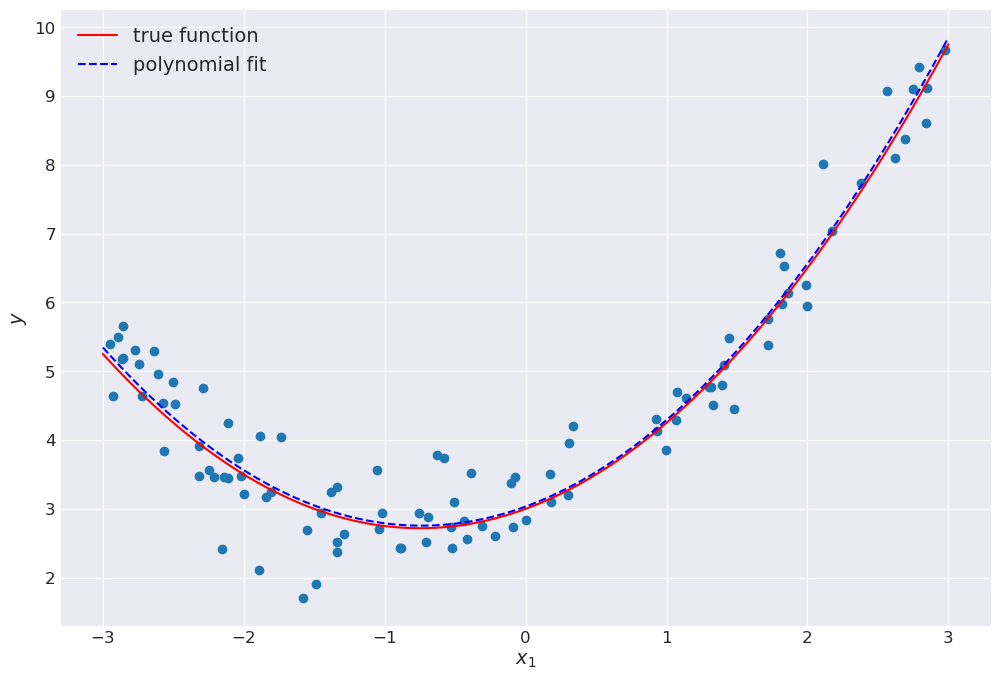

In [8]:
# plot again with the estimated polynomial fit to the function
# display the target data, along with the true quadratic function that generated the relationship between
# the variable x and the target value y
plt.scatter(X, y);

# plot the true function
x_h = np.linspace(-3.0, 3.0, 100)
y_h = 0.5 * x_h**2.0 + 0.75 * x_h + 3.0
plt.plot(x_h, y_h, 'r-', label='true function')

# plot the parametters fitted by the polyfit() function
y_fit = a * x_h**2.0 + b * x_h + c
plt.plot(x_h, y_fit, 'b--', label='polynomial fit')

plt.xlabel(r'$x_1$')
plt.ylabel('$y$')
plt.legend();

The general technique though works like this.  Imagine that we use a function with
two features:

$$
y = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2
$$

However, we will relate the features like this $x_2 = x_1^2$.
If we originally only have features $x_1$, we could create the
$x_2$ features by simply squaring the $x_1$ features we are given and
adding as an additional column of input to our input training data.

For example, we can use Scikit-learn's `PolynomialFeatures` class
to do this.

In [9]:
X_squared = X**2
print(X[:5])
print(X_squared[:5])

[ 1.71781729  2.62447513 -1.80910192 -0.44116914 -0.41943126]
[2.95089623 6.88786968 3.27284977 0.19463021 0.17592258]


In [10]:
from sklearn.preprocessing import PolynomialFeatures
# create all degree 2 combination features 
poly_features = PolynomialFeatures(degree=2, include_bias=False)

# sklearn expects a column matrix instead of a vector
X = X.reshape((m,1))

# create the degree 2 polynomial feature
X_poly = poly_features.fit_transform(X)

In [11]:
print(X.shape)
print(X_poly.shape)

# show the first 5 values of X and of X_poly
print(X[:5,:])
print(X_poly[:5,:])

(100, 1)
(100, 2)
[[ 1.71781729]
 [ 2.62447513]
 [-1.80910192]
 [-0.44116914]
 [-0.41943126]]
[[ 1.71781729  2.95089623]
 [ 2.62447513  6.88786968]
 [-1.80910192  3.27284977]
 [-0.44116914  0.19463021]
 [-0.41943126  0.17592258]]


The additional column in `X_poly` is simply the square of each of the
features in the original data.  Thus column 0 is the $x_1$ linear feature
and column 1 is our $x_2 = x_1^2$ square feature column.

We can then fit this data with a regular linear regression using
a Scikit-learn `LinearRegression` object to also estimate the parameters.

In [12]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(3.033777806438635, array([0.75050739, 0.50694293]))

In [13]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_



(4.681769247712493, array([0.61989974]))

In [14]:
(a,b) = np.polyfit(X.reshape(100), y, 1)
a, b

(0.6198997402110838, 4.681769247712492)

You should get pretty much the exact same fit using this method as with 
the `np.polyfit()` method, so we won't plot the true function and fit
again.  

With either method the fit is not bad, the model usually estimates something like
$\hat{y} = 0.51 x_1^2 + 0.79 x_1 + 2.98$ when in fact the original
function was $y = 0.5x_1^2 + 0.75x_1 + 3.0 + \text{gaussian noise}$

(**NOTE**: we are not setting a random seed, so each time you run a different set
of random points and noise are generated, thus don't expect your results to be
exactly the same as discussed here, nor will they be the same if you
run the notebook multiple times).

When there are multiple features, the `PolynomialFeatures` can add not only
degree powers of individual features, but all possible combinations of
features and their degrees as well. For example, if there were two
features $a$ and $b$, `PolynomialFeatures` with `degree=3` would
add not only $a^2$, $a^3$, $b^2$ and $b^3$ but also the combinations $ab$,
$a^2b$ and $ab^2$.

In [15]:
# Create example of 10 samples of 2 random features
X = np.random.randint(-7, 7, (10,2))

# add all combinations of features up to degree 3
poly_features = PolynomialFeatures(degree=3, include_bias=False)

# transform to add the features, will increase from the 2 features, to
# add in the 7 other combinations mentioned
X_poly = poly_features.fit_transform(X)

# display first 2 rows, so you can check, should be in order
# a, b, a^2, ab, b^2, a^3, a^2b, ab^2, b^3 
X_poly[:2,:]

array([[   5.,   -7.,   25.,  -35.,   49.,  125., -175.,  245., -343.],
       [   1.,    2.,    1.,    2.,    4.,    1.,    2.,    4.,    8.]])

In [16]:
X_poly.shape

(10, 9)

## 4.4 Learning Curves

As we mentioned before, if you perform high-degree polynomial regression, you
will likely fit the data much better than with plain linear regression.
But when you do this, are you actually building a better model of the data?
**NOTE**: This is an important concept, all supervisied machine learning
is an attempt to build the best most general model that fits the data and
will generalize well to new data.  A model is not better just because it
fits the data you create/train it with well.


For example, we can use our quadratic system again, and
fit a linear, quadratic and a 300-degree polynomial to the data and
see what we get.


In [17]:
# create a set of random data, system is governed by a quadratic relationship

# number of samples in our system
m = 100

# x values randomly range from -3 to 3
X = 2 * np.random.rand(m, 1) - 1

# create y targets
y = 0.5 * X**2.0 + 0.75 * X + 3.0

# but make the y targets a bit noisy
y = y + np.random.randn(m, 1)*0.5

In [18]:
# fit a linear regression model to the data
lin_reg = LinearRegression()
lin_reg.fit(X, y);

In [19]:
# Now fit a polynomial regression of degree 2
poly_features_deg2 = PolynomialFeatures(degree=2, include_bias=False)
X_deg2 = poly_features_deg2.fit_transform(X)

deg2_reg = LinearRegression()
deg2_reg.fit(X_deg2, y)

LinearRegression()

In [20]:
# now fit a polynomial regression of degree 300
poly_features_deg300 = PolynomialFeatures(degree=300, include_bias=False)
X_deg300 = poly_features_deg300.fit_transform(X)

deg300_reg = LinearRegression()
deg300_reg.fit(X_deg300, y)

LinearRegression()

In [21]:
X_deg300.shape

(100, 300)

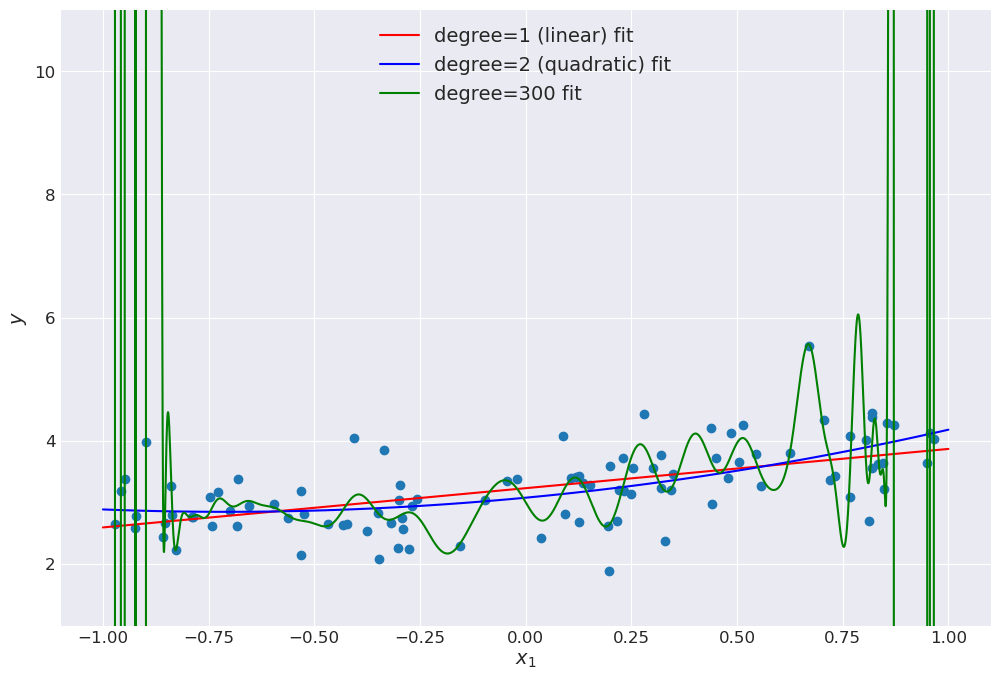

In [22]:
# visualize the fit of our 3 models

# first show the original quadratic noisy data points
plt.scatter(X, y);

# x points evenly spaced so we can plot our fitted models accurately
x_h = np.linspace(-1.0, 1.0, 100).reshape(100,1)

# display the linear fit model
yhat_lin = lin_reg.predict(x_h)
plt.plot(x_h, yhat_lin, 'r-', label=r'degree=1 (linear) fit');

# display the degree 2 fit model
x_h_deg2 = poly_features_deg2.fit_transform(x_h)
yhat_deg2 = deg2_reg.predict(x_h_deg2)
plt.plot(x_h, yhat_deg2, 'b-', label=r'degree=2 (quadratic) fit')

# display the degree 300 fit model, to see the true curve you need a much
# higher mesh resolution here
x_h = np.linspace(-1.0, 1.0, 10000).reshape(10000,1)
x_h_deg300 = poly_features_deg300.fit_transform(x_h)
yhat_deg300 = deg300_reg.predict(x_h_deg300)
plt.plot(x_h, yhat_deg300, 'g-', label=r'degree=300 fit')

# restrict the y axis so we can actually see the display
plt.ylim(1, 11)

# label the figure
plt.xlabel(r'$x_1$')
plt.ylabel('$y$')
plt.legend();

If you looked at the MSE cost functions you would see that of course the degree 300
model achieves the lowest cost.  It does this because it wiggles and squirms and
passes through as many of the points as it can in the data it is fitting.  But the degree 300
model is not the better model.  It is not modeling the true quadratic relationship,
which we know actually governs this data.  It is really modeling the noise.  The
extra parameters only serve to allow the model to fit well the incidental
noise that is present in the measured data.  But it is not capturing well
the true relationship that governs this data.  In fact, you can see on the ends
how poorly this model will do when predicting new data it was not trained
with.  The huge swings of the predictions are going to have huge prediction
errors for new data from this quadratic system.  In fact the degree 300 model
will be extremely poor at generalizing to new data, especially when compared to
a model that is correct in terms of the type of function that is generating
and governing the system.

We have already seen another method in previous lectures of ways we can
measure a model's generalization performance.  We have previously used cross-validation
to do this, holding back some of the data when training/fitting a model
so we can evaluate how well it does on unseen data.   If a model performs
well on the data you train it with, but generalizes poorly according to
held back test data or cross-validation data, then the model is 
overfitting.  If it performs poorly on both the fitting data and the validation
data, then it is underfitting.  This is one way to tell when a model is too
simple or too complex.  Here the degree 300 polynomial is too complex and it
is overfitting the data.

A common way to differentiate between under and overfitting is to look at
**learning curves**.  A learning curve is a plot where we show the cost function on both
the data we are training with, and on validation/test data that has not been seen
by the model.  If we are using an iterative algorithm like gradient descent, we can
plot the performance for each iteration or epoch of training.  Alternatively, 
we can train a with different train/validation size splits and plot the
cost as a function of the training set size.  This latter method is necessary when using
exact solutions like the normal equation.

For example, we can use the `train_test_split` function to try out a linear or polynomial
fit when we train with small or large amounts of the available data.  The following example
from our textbook defines a function that plots the learning curves of a model given some
data using this method of performing multiple train/validation splits.  It actually performs all splits
starting with only 1 data point for training, then 2, etc, trains a model, and plots the 
achieved cost on both training and test data over all of these train/test splits.

In [23]:
# the following examples are much clearer if we have a much larger set of data.  With only 100
# samples, there is not a whole lot of difference in performance of the linear and quadratic fit.
# create a set of random data, system is governed by a quadratic relationship

# number of samples in our system
m = 10000

# x values randomly range from -3 to 3
X = 2 * np.random.rand(m, 1) - 1

# create y targets
y = 0.5 * X**2.0 + 0.75 * X + 3.0

# but make the y targets a bit noisy
y = y + np.random.randn(m, 1) * 0.1

In [24]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    """Plot learning curves obtained with training the given scikit-learn model
    with progressively larger amounts of the training data X.
    
    Nothing is returned explicitly from this function, but a plot will be created
    and the resulting learning curves displayed on the plot.
    
    Parameters
    ----------
    model - A scikit-learn estimator model to be trained and evaluated.
    X - The input training data
    y - The target labels for training
    """
    # we actually split out 20% of the data solely for validation, we train on the other 80%
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    
    # keep track of history of the training and validation cost / error function
    train_errors, val_errors = [], []
    
    # train on 1 to m of the data, up to all of the data in the split off training set
    for m in range (1, len(X_train)):
        # fit/train model on the first m samples of the data
        model.fit(X_train[:m], y_train[:m])
        
        # get model predictions
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        
        # determine RMSE errors and save history for plotting
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
        
    # plot the resulting learning curve
    plt.plot(np.sqrt(train_errors), 'r-', linewidth=2, label='train')
    plt.plot(np.sqrt(val_errors), 'b-', linewidth=2, label='val')
    plt.xlabel('Training set size')
    plt.ylabel('RMSE')
    plt.legend(fontsize=18)

First the learning curve of a plain Linear Regression model (a straight line).

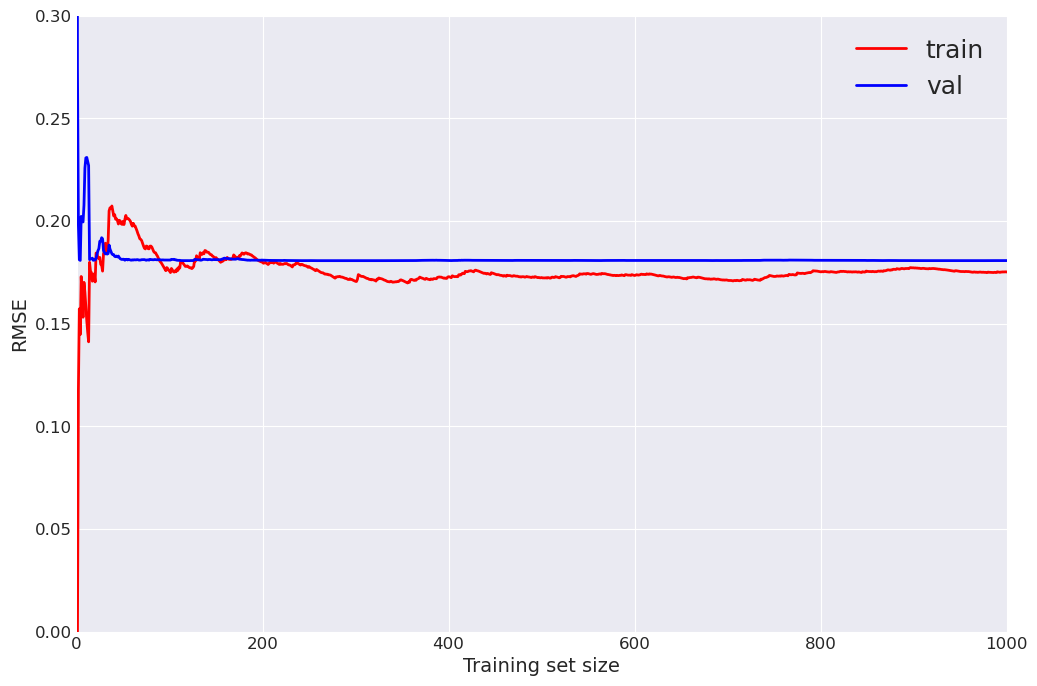

In [25]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.ylim(0, 0.3)
plt.xlim(0, 1000);

Whether you plot the train and validation error for successive epochs of an iterative gradient
descent, or like we have done here where we plot the errors as a result of changing the amount
of data we train with, in either case you will get a similar curve and be able to derive the
same information.

Here recall that our data is a quadratic function, and the linear model straight line underfits
this data.  As you would expect, when you train with a small amount of data (or a small number
of epoch), the validation error will be very high.  The training error is low here because
of course a linear model will have a small amount of error if fit to 2, 3 or a small number of
points.  But this error increases rapidly as more points are used and the line cannot fit the
data well anymore.

Recall there are two sources of error here for the linear model, the fit of a line to a quadratic
function will never be optimal.  But there is also random noise in the data, that will never
be accounted for no matter what model you are using.  Here for the training error, initially
the error is very small, but eventually it reaches a plateau at which point the average error
no longer changes much.  

For the validation error, as we mentioned, when the model is trained on very little data it performs
extremly poorly in trying to generalize to the validation data.  But its performance improves
as more data is used.  However once a straight line cannot do a good job modeling the
data, the error stops improving, very close to the training error plateau.

This is typical of an underfitting model.  Both curves reach a plateau that are fairly close 
to one another, and fairly high (which is bad, we are trying to minimize the error cost here).

We can likewise look at the very high degree polynomial model, which we have stated is overfitting
the data.

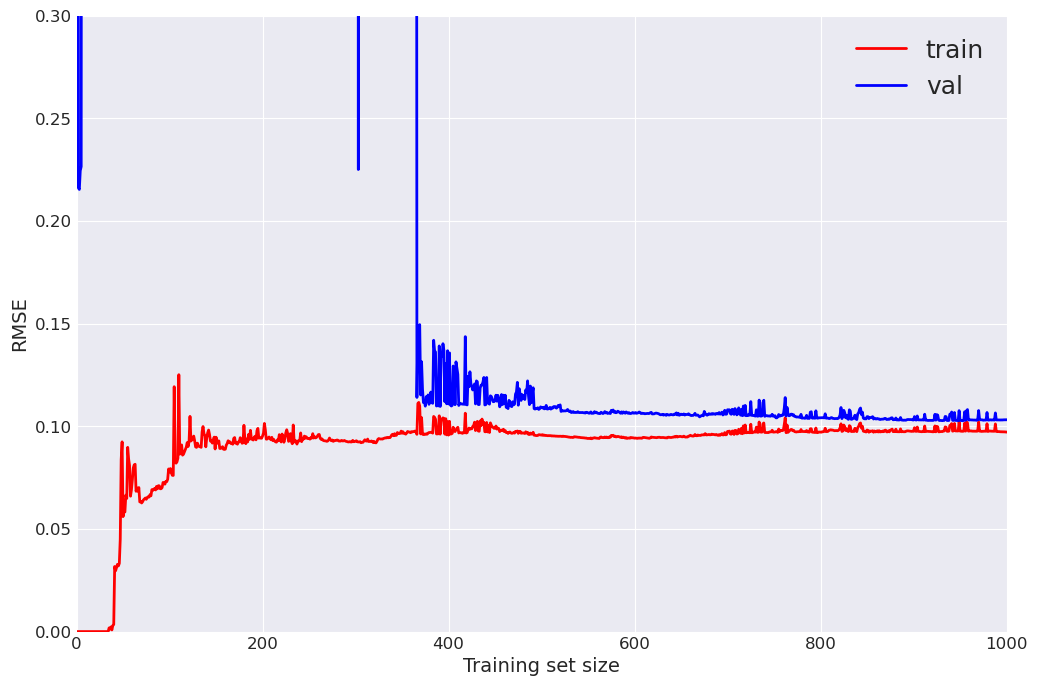

In [26]:
from sklearn.pipeline import Pipeline

# an example of scikit-learn API here, a pipeline is just a sequence of fit/transform/predict objects,
# so even though our data is only degree-1, the pipeline will first transform to the
# high-degree model, then fit the linear regression to the high-dimensional polynomial transformed data
polynomial_regression = Pipeline([
    ('poly_features', PolynomialFeatures(degree=100, include_bias=False)),
    ('lin_reg', LinearRegression()),
])

plot_learning_curves(polynomial_regression, X, y)
# error is so big in spots, we have to clip it
plt.ylim(0, 0.3)
plt.xlim(0, 1000);

As mentioned in the textbook, these curves do look similar here, and it can sometimes be
difficult to distinguish under and over fitting.  This is a fairly high degree polynomial
fit here with 100 degrees of freedom.  The overfitting is of course much
more obvious if you try fitting an even higher degree polynomial.  There are some differences between this overfitting
example and the previous underfitting example,
especially if you look at even worse overfitting by using even more complex polynomial
models:

- The error on the training data is a bit lower than with the Linear Regression model.  This is because
the polynomial model has more wiggle, so it can perfectly fit the data for much longer, and can
overfit and model some of the noise in the data as well.
- There will usually be a gap between the curves when overfitting is the prevalent problem.
For a degree-100 model you won't always see this.  But validation will be much worse for degree 200
or higher polynomial degrees here than on the training data.

When the model performs significantly better on the training data than with the validation data, then
you are likely seeing overfitting.  However, if you could use a much larger training set, the
two curves would continue to get closer (as they often do here for a degree-100 polynomial).  This is
because even if your model is overpowered, if you have lots of data it still cannot continue to
overfit well for the large data set, and will thus begin to demphasize or remove the
higher-order parameters that are not useful in getting a good fitting and generalizable model.

The quadratic model will thus have curves where the training data error is as good or
better than the previous 2, and the validation error will approach the same low
error levels as the training data error.
  

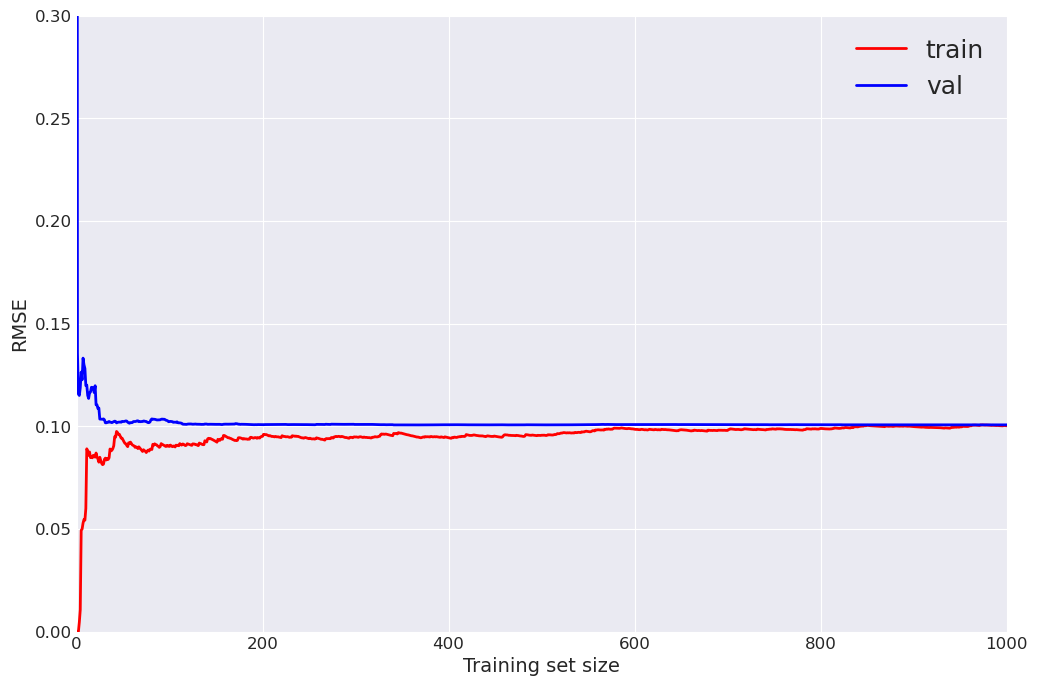

In [27]:
from sklearn.pipeline import Pipeline

# an example of scikit-learn API here, a pipeline is just a sequence of fit/transform/predict objects,
# so even though our data is only degree-1, the pipeline will first transform to the
# 2nd-degree model, then fit the linear regression to the 2nd-dimensional polynomial transformed data
quadratic_regression = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('lin_reg', LinearRegression()),
])

plot_learning_curves(quadratic_regression, X, y)
plt.ylim(0,0.3)
plt.xlim(0, 1000);

### The Bias/Variance Tradeoff

You should always be aware that there are multiple sources of generalization error in the data you have that you want
to try and build a model of.  

**Bias** - This part of the generalization error is due to wrong assumpitons, such as assuming a linear
model when the data is actually quadritic.  A high-bias model is most likely to underfit the training data.

**Variance** - This part of generalization error is due to a model's excessive sensitivity to small
variations in the training data.  A model with many degrees of freedom (e.g. many weights or parameters to be fit, like a high-degree polynomial fit) is likely to have high variance, and thus to overfit the
training data.

**Irreducible error** - This part of generalization error is due to the noisiness of the data itself.
This error cannot be reduced from a more accurate model, the most accurate model can never eliminate
irreducible noise from the data.  The only way to reduce this part of the error is to clean the data
(e.g. fix or use more accurate sensors and methods to collect the data, or detect outliers or
other ways to clean data after the fact of noise).

Bias and variance are two ends of a spectrum, increasing a models complexity will typically increase
its variance and reduce its bias.  Conversely reducing a model's complexity will increase its bias
and reduce its variance.  Thus you can tradeoff one for the other, and you get the best balance
when your model accurately reflects the process that generates the relationship between the
data you are trying to model.

![Bias vs. Variance tradeoff](../../figures/bias-vs-variance.png)